# Performance comparison studies of tree-based algorithms used for model-agnostic anomaly detection

In this notebook, we study the performance of different training settings for tree-based models and interpret the results.

We will use the LHCO R&D dataset as a benchmark for these comparisons and use it to conduct weakly supervised anomaly detection with tree-based algorithms, in particular `scikit-learn`'s `HistGradientBoostingClassifier`, since this - including proper ensembling - gave us the best out-of-the-box performance so far. 

The following studies are conducted:

**1.  Interpreting the performance improvement of the ensembling:**

One thing we found early is that using the mean prediction of an ensemble of different models improves the result significantly in comparison to just using individual models. In this study, we will train a single ensemble (based on 10 separately trained models), compare their performance and try to provide an intuition about where the improvement comes from


First, we import all necessary modules and functions, before we start with the individual studies

In [6]:
import os
from os.path import join
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from utils import load_lhco_rd, add_gaussian_features, multi_roc_sigeffs, train_model_multirun, get_losses, eval_ensemble, eval_single_model
from plot_utils import plot_losses, plot_sic_curve_comparison

## Study 1.: Compare performance of individual models with the ensemble model

Previous studies suggested that using model ensembling is key in improving the performance of the classifier. We investigate this further by conducting the following study:

We train a single ensemble (consisting of 10 models) and then plot the SIC curves of both the individual models as well as for the entire ensemble for comparison.

In a second study, we test a common hypothesis about why ensembling improves the overall performance: For a single model, predictions on some signal events might be suboptimal. However, when looking at a set of ten model predictions, there will be models that pick up on this particular signal event better and thus provide a higher prediction than the other models. Taking the average prediction over all models then shifts the prediction of the signal event up, which improves the overall performance.

To investigate whether this intuition is accurate, we take the models from the previous study and make a histogram for background and signal predictions in the case of individual model predictions as well as mean model predictions. In an ideal case, the signal distribution of the mean predictions should be shifted to higher values, while background events stay around the random prediction value of 0.5 (not 0 because of the "background-vs-background" nature of the weak classification scheme).

In [2]:
# Load data from LHCO R&D dataset
data = load_lhco_rd("./lhco_rd")

In [3]:
# How often to re-run the entire ensemble training procedure
num_runs = 1

# How many models constitute a single ensemble
ensembles_per_model = 10

max_iters = 100

compute_val_weights = True

# Get predictions of all ensembles
full_losses, models = train_model_multirun(
    data,
    num_runs=num_runs, ensembles_per_model=ensembles_per_model,
    max_iters=max_iters, compute_val_weights=compute_val_weights,
    cv_mode="random", early_stopping=True)

full_predictions = eval_ensemble(models, data, losses=full_losses)
# Get TPRs and FPRs for all ensembles
tpr_vals_noG, fpr_vals_noG = multi_roc_sigeffs(full_predictions, data["y_test"])

Run 1/1


In [14]:
# Get individual model predictions:
for idx, mod in enumerate(models[0]):
    tmp_ensemble_preds = eval_single_model(mod, data,
                                           val_losses=full_losses["run_0"][f"model_{idx}"]["val_loss"]
                                           ).reshape((1, -1))
    
    if idx == 0:
        ensemble_preds = tmp_ensemble_preds
    else:
        ensemble_preds = np.vstack((ensemble_preds, tmp_ensemble_preds))

Plot ensemble SIC and SIC of individual models (we can use `multi_ROC_sigeffs` for one ensemble instead of multiple runs here):

/tmp/ipykernel_7367/1679600166.py:3: RuntimeWarning: divide by zero encountered in true_divide
  individual_sics = individual_tprs/np.sqrt(individual_fprs)
/tmp/ipykernel_7367/1679600166.py:3: RuntimeWarning: invalid value encountered in true_divide
  individual_sics = individual_tprs/np.sqrt(individual_fprs)
/tmp/ipykernel_7367/1679600166.py:5: RuntimeWarning: divide by zero encountered in true_divide
  ensemble_sics = tpr_vals_noG/np.sqrt(fpr_vals_noG)
/tmp/ipykernel_7367/1679600166.py:5: RuntimeWarning: invalid value encountered in true_divide
  ensemble_sics = tpr_vals_noG/np.sqrt(fpr_vals_noG)
/tmp/ipykernel_7367/1679600166.py:14: RuntimeWarning: divide by zero encountered in true_divide
  tmp_mask = (1/np.sqrt(individual_fprs[i]*data["y_test"][data["y_test"]==0].shape[0])) < 0.2
/tmp/ipykernel_7367/1679600166.py:18: RuntimeWarning: divide by zero encountered in true_divide
  tmp_mask = (1/np.sqrt(fpr_vals_noG.flatten()*data["y_test"][data["y_test"]==0].shape[0])) < 0.2


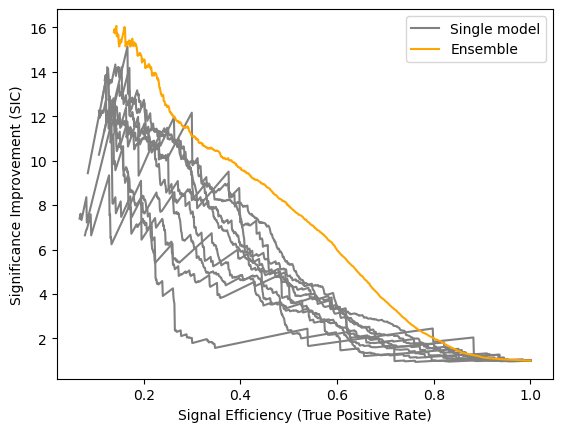

In [16]:
# Compute SICs of individual models
individual_tprs, individual_fprs = multi_roc_sigeffs(ensemble_preds, data["y_test"])
individual_sics = individual_tprs/np.sqrt(individual_fprs)

ensemble_sics = tpr_vals_noG/np.sqrt(fpr_vals_noG)

## Plot individual as well as best SIC using stat. criterion on relative error on BG events:
for i in range(individual_tprs.shape[0]):
    if i == 0:
        tmp_label = "Single model"
    else:
        tmp_label = None
        
    tmp_mask = (1/np.sqrt(individual_fprs[i]*data["y_test"][data["y_test"]==0].shape[0])) < 0.2
    
    plt.plot(individual_tprs[i][tmp_mask], individual_sics[i][tmp_mask], color="gray", label=tmp_label)

tmp_mask = (1/np.sqrt(fpr_vals_noG.flatten()*data["y_test"][data["y_test"]==0].shape[0])) < 0.2
plt.plot(tpr_vals_noG.flatten()[tmp_mask], ensemble_sics.flatten()[tmp_mask], color="orange", label="Ensemble")
plt.xlabel("Signal Efficiency (True Positive Rate)")
plt.ylabel("Significance Improvement (SIC)")
plt.legend(loc="upper right")
plt.savefig("./individual_vs_ensemble_SIC_comparison_statcriterion0.2.pdf", bbox_inches="tight")
plt.show()
plt.close()

Plot histograms of individual predictions and mean predictions (separately for BG and Signal):

Histogram of ensemble mean vs. individual model background predictions:


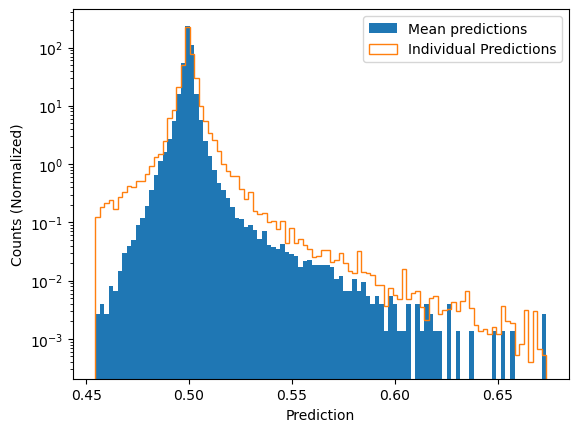

Histogram of ensemble mean vs. individual model signal predictions:


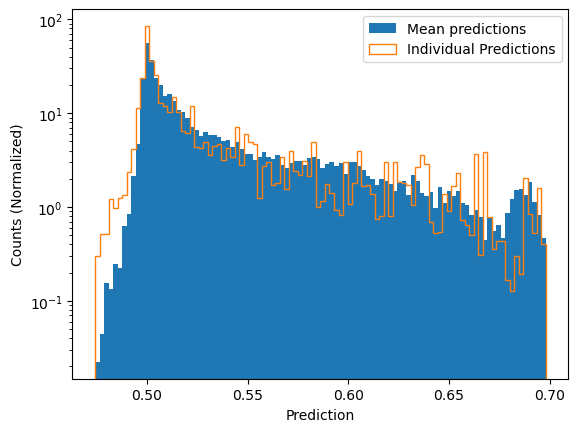

In [18]:
full_bg_preds = ensemble_preds[:, data["y_test"]==0]
full_sig_preds = ensemble_preds[:, data["y_test"]==1]
mean_bg_preds = np.mean(full_bg_preds, axis=0)
mean_sig_preds = np.mean(full_sig_preds, axis=0)

print("Histogram of ensemble mean vs. individual model background predictions:")
_, edges, _ = plt.hist(mean_bg_preds, bins=100, label="Mean predictions", density=True)
plt.hist(full_bg_preds.flatten(), bins=edges, label="Individual Predictions", density=True, histtype="step")
plt.legend(loc="upper right")
plt.xlabel("Prediction")
plt.ylabel("Counts (Normalized)")
plt.yscale("log")
plt.savefig("./pred_hist_compare_bg.pdf", bbox_inches="tight")
plt.show()
plt.close()

print("Histogram of ensemble mean vs. individual model signal predictions:")
_, edges, _ = plt.hist(mean_sig_preds, bins=100, label="Mean predictions", density=True)
plt.hist(full_sig_preds.flatten(), bins=edges, label="Individual Predictions", density=True, histtype="step")
plt.legend(loc="upper right")
plt.xlabel("Prediction")
plt.ylabel("Counts (Normalized)")
plt.yscale("log")
plt.savefig("./pred_hist_compare_sig.pdf", bbox_inches="tight")
plt.show()
plt.close()

**Discussion of Results:**

The SIC curves clearly show that the ensembling improves the models above the level of the individual model performance, since the ensemble SIC curve achieves better values than the individual SICs throughout almost the entire signal efficiency range.

We also observe that the intuition about why the ensembling improves the results is correct: The mean signal predictions are moved more towards the tail and predictions that are below the random prediction of 0.5 are entirely removed by taking the mean. Interestingly, also the background predictions get "better" in a sense that they are more contained around the random value of 0.5, and fewer predictions exist in the tails (especially a strong tail towards higher values would be problematic).

The reason for this effect is similar to the one of the signal events: Since we expect "random" predictions from the data vs background task for background events (since essentially we are trying to distinguish background events from background events), we will see the predictions being above 0.5 for some models and below 0.5 for others. Some individual model predictions might even predict a rather high or low value that is situated in the tails which we see in the respective distribution. However, when taking the mean over all model predictions, the values are shifted more to the central value around 0.5, and thus the mean prediction distribution has this more contained shape.